In [1]:
import numpy as np 
import cv2
import math
import matplotlib.pyplot as plt

In [2]:
# GAUSSIAN FILTER CREATED FROM SCRATCH WITH VARIABLE SIZE,k, AND VARIABLE STANDARD DEVIATION,sigma
def gaussian_blur(image,k,sigma):
    A = 0 
    mid = int((k-1)/2)
    matrix = np.zeros((k,k))
    for i in range(k):
        for j in range(k):
            temp = math.exp(-((((i-k)**2) + ((j-k)**2))/(2*(sigma**2))))
            A+=temp
            matrix[i,j] = temp
    matrix =matrix/A
    a = cv2.filter2D(image,-1,matrix)
    return a

# sobel filter created from scratch. edge_type=0 implies horizontal sobel. edge_type=1 implies vertical sobel. 
def sobel_filter(image,edge_type):
    if edge_type==0:
        kernel = np.array([[-1,-2,-1],[0,0,0],[1,2,1]]) # covers dark to bright transition edges
        kernel_1 = np.array([[1,2,1],[0,0,0],[-1,-2,-1]]) # covers bright to dark transition edges
    if edge_type==1:
        kernel = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
        kernel_1 = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    edges = cv2.filter2D(image,-1,kernel)
    edges_1 = cv2.filter2D(image,-1,kernel_1)
    for i in range(edges.shape[0]):
        for j in range(edges.shape[1]):
            if np.argmax(np.array([abs(edges[i,j]),abs(edges_1[i,j])]))==1: #find the max between kernel and kernel_1
                edges[i,j] = edges_1[i,j]
    return (abs(edges)>=120)*np.ones(edges.shape)*edges*(1/8) #absolute thresholding to avoid noise

# calculation of alpha using g_x and g_y
def alpha_matrix(g_x,g_y):
    angle_array = np.array([0,45,90,-45,-90])              #the round-off angles 
    alpha = np.arctan2(g_y,g_x)                            #calculation of alpha angles
    alpha = alpha*(180.0/np.pi)          
    for i in range(alpha.shape[0]):
        for j in range(alpha.shape[1]):
            if alpha[i,j]>90:                              #convert the alpha angles to the range of [-90,90]
                diff = angle_array - (alpha[i,j]-180)      #find the difference with the round-off angles 
            elif alpha[i,j]<-90:
                diff = angle_array - (alpha[i,j]+180)
            else:
                diff = angle_array - alpha[i,j]
            alpha[i,j] = angle_array[np.argmin(abs(diff))] #find the round-off angle closest to the alpha angle
    return alpha

# non-max suppression
def non_max_suppression(M,alpha):
    dict_add = {0:[0,1],45:[-1,1],90:[-1,0],-45:[1,1],-90:[1,0]} #neighbours to check based on the alpha angle
    g_n = np.zeros(M.shape)
    for i in range(alpha.shape[0]):
        for j in range(alpha.shape[1]):
            [a,b] = dict_add[alpha[i,j]]
            if i+1!=alpha.shape[0] and j+1!=alpha.shape[1]:
                temp_array = np.array([M[i,j],M[i+a,j+b],M[i-a,j-b]]) #finding the maximum among the corresponding neighbours
                if np.argmax(temp_array)==0:
                    g_n[i,j] = M[i,j]   #assigning values to g_n based on the neighbouring values in M
    return g_n

# double thresholding
def hysterisis_thresholding(g_n): 
    max_value = np.max(g_n) #finding the max value in g_n
    t_h = 0.1*max_value     #higher threshold
    t_l = 0.5*t_h           #lower threshold
    g_nh = (g_n>t_h)*g_n    #thresholding based on the higher threshold
    g_nl = (g_n>t_l)*g_n    #thresholding based on the lower threshold
    g_nl_ = g_nl - g_nh     #storing values between lower and higher thresholds 
    return g_nl_,g_nh    

# edge-linking
def edge_linking(g_nl_,g_nh):
    out = np.zeros(g_nh.shape)
    neigh = np.array([[1,1],[0,1],[1,0],[-1,1],[1,-1],[0,-1],[-1,-1],[-1,0]]) #8-neighbours
    for i in range(g_nl_.shape[0]):
        for j in range(g_nl_.shape[1]):
                temp_neigh = neigh + np.array([i,j])                  #calculating the neighbour locations
                for p in range(temp_neigh.shape[0]):
                    try:
                        value = g_nh[temp_neigh[p,0],temp_neigh[p,1]] #checking if any of the 8_neighbours is non zero in g_nh
                        if value!=0:
                            out[i,j] = g_nl_[i,j]
                            break
                    except:
                        continue 
    return out
            

In [3]:
#image can be either RGB or grayscale
#k is the size of the gaussian filter applied
#sigma is the corresponding standard-deviation of the gaussian filter
def canny_edges(image_path,k,sigma):
    image = cv2.imread(image_path)
    if len(image.shape)==3:                           #if the image is coloured
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) #conversion of BGR to RGB
        image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)#RGB to grayscale
    i_g = gaussian_blur(image,k,sigma)                #applying gaussian filter
    g_x = sobel_filter(image,0)                       #horizontal sobel filter
    g_y = sobel_filter(image,1)                       #vertical sobel filter 
    M = np.sqrt((g_x**2) + (g_y**2))                  #calculation of M 
    M = (M/M.max())*255                               #normalizing M to 255
    alpha = alpha_matrix(g_x,g_y)                     #calculation of alpha
    g_n = non_max_suppression(M,alpha)                #non-max suppression 
    g_nl_,g_nh = hysterisis_thresholding(g_n)         #hysterisis thresholding
    g_nl__ = edge_linking(g_nl_,g_nh)                 #edge-linking
    edges = g_nl__ + g_nh                             #final answer
    return (edges>20)*np.ones(edges.shape)*255        #thresholding
    

RUN THE CODE IN THE BELOW CELL

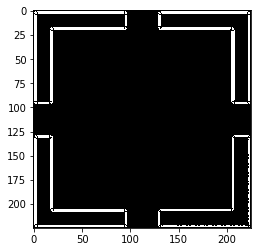

True

In [393]:
edges = canny_edges('harris_corner_1.png',24,4)
plt.imshow(edges,cmap='gray')
plt.show()
cv2.imwrite('abc.png',edges)

BUILT-IN 

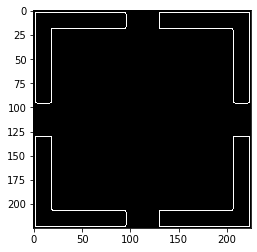

True

In [5]:
image = cv2.imread('/home/chennuri/chennuri_prateek/COURSES/3D_CV/assignment-1/canny_edge_detection/result_1/input.png')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
edges = cv2.Canny(image,20,70)
plt.imshow(np.uint8(edges),cmap='gray')
plt.show()
cv2.imwrite('result1.png',edges)